分析 github star 的传播

## 准备数据

 * 某一个项目的所有 `star` 事件 
 * 上述事件中所有涉及到的用户的 Followers / Followings  



In [1]:
from github import Github
import itertools

def get_star_timelime(repo_fullname):
    repo = Github().get_repo(repo_fullname)
    events = repo.get_events()
    return filter(lambda x:x.type == 'WatchEvent', events)


In [2]:
events = get_star_timelime("ftao/vpn-deploy-playbook")

http://pygithub.readthedocs.org/en/stable/github_objects/Event.html
http://pygithub.readthedocs.org/en/stable/github_objects/NamedUser.html

In [4]:
first_event = list(itertools.islice(events, 0, 1))[0]
print(first_event.type, first_event.actor.login, first_event.created_at)

WatchEvent SquirrelMajik 2016-01-08 12:27:04


In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()

In [41]:
repo_fullname = "ftao/vpn-deploy-playbook"
repo = Github().get_repo(repo_fullname)
events = list(repo.get_events())
print(len(events))

300


In [ ]:
ts = pd.Series(np.ones(len(events)), index=pd.to_datetime([e.created_at for e in reversed(events)]))
ts = ts.cumsum()
ts.plot()

问题来了， github API 只能返回大概300条最近的事件, 而且还可能包含其他类型的事件。
这个的数据太少了， 对于一些很活跃的仓库，1天的star 数就可能超过这个值。

### github-archive 

https://www.githubarchive.org/ 解决了这个问题, 保存了所有历史的事件。

我们来导出一封，某个仓库的所有历史star 数据。 
有几种方式可以使用这个数据，

 * 下载原始的数据，自己解析
 * 查询保存在 Google Big Query 里面的数据
 
我们使用第二种方法. 


In [7]:
repo_fullname = "ftao/vpn-deploy-playbook"
repo = Github().get_repo(repo_fullname)
print(repo.stargazers_count)
print(repo.created_at.strftime("%Y-%m-%d"))

602
2013-07-21


In [8]:
s = pd.read_csv('data/star_2015.csv', parse_dates=[1], index_col=1)
s = s.iloc[::-1]
s['count'] = np.ones(len(s))

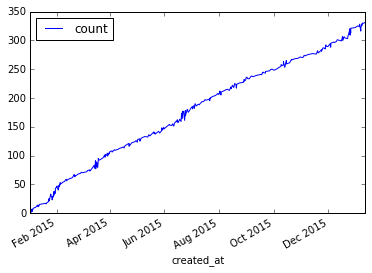

In [9]:
s = s.cumsum()
s.plot()